In [1]:
import os
import shutil
from google.colab import drive

drive.mount('/content/drive')

path_MG = '/content/drive/MyDrive/00gerem00/DL-AI-Project'
path_LM = '/content/drive/MyDrive/lorenzomeroni02/DL-AI-Project'

if os.path.exists(path_MG):
    working_dir = path_MG
    print(f"Working in MG folder: {working_dir}")
elif os.path.exists(path_LM):
    working_dir = path_LM
    print(f"Working in LM folder: {working_dir}")
else:
    print("Error: Project folder not found in Drive. Check the paths.")
    working_dir = None

if working_dir:
    os.chdir(working_dir)
    zip_filename = 'leather-defect-classification.zip'
    fast_local_dir = '/content/fast_dataset'

    if os.path.exists(zip_filename):
        print(f"Great! {zip_filename} found on Drive.")

        if not os.path.exists(fast_local_dir):
            os.makedirs(fast_local_dir, exist_ok=True)
            !unzip -q {zip_filename} -d {fast_local_dir}
    else:
        print(f"Error: {zip_filename} not found in your Drive folder. Please check if you uploaded it correctly to {working_dir}.")

Mounted at /content/drive
Working in LM folder: /content/drive/MyDrive/lorenzomeroni02/DL-AI-Project
Great! leather-defect-classification.zip found on Drive.


In [2]:
from torchvision.datasets import ImageFolder

base_dir = '/content/fast_dataset'

content = os.listdir(base_dir)
subfolders = [f for f in content if os.path.isdir(os.path.join(base_dir, f))][0]
data_dir = os.path.join(base_dir, subfolders)

dataset = ImageFolder(
    root = data_dir,
    transform = None)

print(f"Total number of images: {len(dataset)}")
print(f"Classes found: {dataset.classes}")
print(f"Index mapping: {dataset.class_to_idx}")

Total number of images: 3600
Classes found: ['Folding marks', 'Grain off', 'Growth marks', 'loose grains', 'non defective', 'pinhole']
Index mapping: {'Folding marks': 0, 'Grain off': 1, 'Growth marks': 2, 'loose grains': 3, 'non defective': 4, 'pinhole': 5}


In [3]:
from PIL import Image

dataset.samples = [s for s in dataset.samples if Image.open(s[0]).size == (227, 227)]
dataset.imgs = dataset.samples
dataset.targets = [s[1] for s in dataset.samples]
print(f"{len(dataset)} images")

3598 images


In [4]:
import torch
from torch.utils.data import random_split

train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

print(f"Completed split: {len(train_set)} training set, {len(val_set)} validation set, {len(test_set)} test set")

Completed split: 2518 training set, 540 validation set, 540 test set


# **Model 2: Custom Convolutional Autoencoder Classifier**

## **Data Preprocessing & DataLoader**

In this section, we set up the data transformations and the DataLoader instances. Since the main goal of our Autoencoder is to achieve a highly accurate reconstruction of the original images, unlike the ResNet-18 classifier, we had to take a completely different approach for the preprocessing pipeline:

* We decided to skip data augmentation entirely. This means we purposely left out transformations like `RandomCrop()`, `RandomRotation()`, and `RandomHorizontalFlip()` from our training set. The reason is simple: the autoencoder needs to learn the actual spatial representation of the leather textures and their defects, without having to struggle with reconstructing pixels that have been artificially shifted or distorted.
* For resizing, we went with a more direct approach. Instead of doing a `Resize(230, 230)` followed by a `RandomCrop(224, 224)`, which we previously used to introduce translation invariance, we just applied a straightforward `Resize((224, 224))` using standard bilinear interpolation. This lets us smoothly compress the original $227 \times 227$ images without throwing away any important information around the borders, where some defects might actually be located.
* Finally, we changed how we handle pixel scaling by avoiding zero-centered normalization. In the ResNet-18 model, we mapped pixels to a [-1.0, 1.0] range to help with gradient flow during classification. Here, though, we only rely on `ToTensor()`, which keeps the pixel values in the [0.0, 1.0] range. This was a strict architectural requirement because the final layer of our decoder uses a Sigmoid activation function, which naturally outputs values between 0 and 1. By making sure the input and output domains match perfectly, our Mean Squared Error (MSE) loss can compute the reconstruction error accurately.

In [6]:
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class TransformSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

ae_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_final = TransformSubset(train_set, transform=ae_transform)
val_final = TransformSubset(val_set, transform=ae_transform)
test_final = TransformSubset(test_set, transform=ae_transform)

batch_size = 32

train_loader = DataLoader(train_final, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_final, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_final, batch_size=batch_size, shuffle=False)

# **Encoder**

In [ ]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Encoder, self).__init__()

        # --- CONVOLUTIONAL FEATURE EXTRACTOR ---
        # Input shape expected: (Batch_Size, 3, 224, 224)
        # We use stride=2 for learnable downsampling instead of MaxPool2d
        self.encoder_cnn = nn.Sequential(

            # Block 1: Halves resolution from 224 to 112
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Block 2: Halves resolution from 112 to 56
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Block 3: Halves resolution from 56 to 28
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Block 4: Halves resolution from 28 to 14
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Block 5: Halves resolution from 14 to 7
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )

        # --- BOTTLENECK (LATENT SPACE) ---
        # The output of the last conv layer is (512, 7, 7)
        self.flatten = nn.Flatten()

        # 512 channels * 7 height * 7 width = 25088 features
        self.fc_latent = nn.Linear(512 * 7 * 7, latent_dim)

    def forward(self, x):
        # Extract spatial features
        x = self.encoder_cnn(x)

        # Flatten the 3D tensor into a 1D vector
        x = self.flatten(x)

        # Compress into the dense latent vector
        latent_vector = self.fc_latent(x)

        return latent_vector

# **Decoder**

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Decoder, self).__init__()

        # --- INITIAL EXPANSION ---
        # Expand the 1D latent vector back to the flattened feature map size (512 * 7 * 7)
        self.fc_expand = nn.Linear(latent_dim, 512 * 7 * 7)

        # Reshape the 1D vector back into a 3D spatial tensor: (Batch_Size, 512, 7, 7)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(512, 7, 7))

        # --- DECONVOLUTIONAL IMAGE RECONSTRUCTOR ---
        # We use ConvTranspose2d to upsample.
        # Crucial: output_padding=1 ensures the resolution exactly doubles at each step.
        self.decoder_cnn = nn.Sequential(

            # Block 1: Doubles resolution from 7 to 14
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            # Block 2: Doubles resolution from 14 to 28
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            # Block 3: Doubles resolution from 28 to 56
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            # Block 4: Doubles resolution from 56 to 112
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            # Block 5: Doubles resolution from 112 to 224 and reduces back to 3 RGB channels
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=3, stride=2, padding=1, output_padding=1),

            # --- CRITICAL: SIGMOID ACTIVATION ---
            # Forces the reconstructed pixel values to be strictly in the [0.0, 1.0] range
            # This perfectly matches the input images transformed by torchvision.transforms.ToTensor()
            nn.Sigmoid()
        )

    def forward(self, x):
        # 1. Expand the latent vector
        x = self.fc_expand(x)

        # 2. Reshape into a 3D feature map
        x = self.unflatten(x)

        # 3. Reconstruct the original image spatially
        reconstructed_image = self.decoder_cnn(x)

        return reconstructed_image

# **Combining Encoder and Decoder**

In [ ]:
import torch
import torch.nn as nn

class ConvolutionalAutoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(ConvolutionalAutoencoder, self).__init__()

        # Instantiate the two halves
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

    def forward(self, x):
        # 1. Compress the input image into the latent space
        latent_vector = self.encoder(x)

        # 2. Reconstruct the image from the latent vector
        reconstructed_image = self.decoder(latent_vector)

        return reconstructed_image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
autoencoder = ConvolutionalAutoencoder(latent_dim=256).to(device)
print("Device:", device)

Device: cuda


# **Model Training**

In [ ]:
import os
import time
import copy
import json
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
REPO_PATH = '/content/drive/MyDrive/00gerem00/DL-AI-Project/'
SAVE_DIR = os.path.join(REPO_PATH, 'models_best_autoencoder')
os.makedirs(SAVE_DIR, exist_ok=True)


lr_values = [1e-3, 5e-4, 1e-4, 1e-5]

num_epochs = 80
patience_es = 10
patience_sched = 3

global_best_loss = float("inf")
global_best_lr = None
global_best_model_state = None

results_summary = {}
full_histories = {}

print(f"Save directory: {SAVE_DIR}")
print("STARTING AUTOENCODER GRID SEARCH WITH FULL MONITORING (LOSS, LR, TIME)")

for initial_lr in lr_values:
    print("\n" + "="*70)
    print(f"TESTING INITIAL LEARNING RATE: {initial_lr}")
    print("="*70)

    # Initialize Autoencoder
    model = ConvolutionalAutoencoder(latent_dim=256).to(device)

    # Use MSE Loss for reconstruction
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=initial_lr)

    # Scheduler and Early Stopping setup
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience_sched)
    counter_es = 0
    best_val_loss_current = float("inf")

    # Tracking History (No accuracy here!)
    history = {
        'train_loss': [],
        'val_loss': [],
        'lr_evolution': [],
        'epoch_duration': []
    }

    for epoch in range(num_epochs):
        start_time = time.time()

        # Track current Learning Rate
        current_lr = optimizer.param_groups[0]['lr']
        history['lr_evolution'].append(current_lr)

        # --- TRAINING PHASE ---
        model.train()
        running_train_loss = 0.0

        for inputs, _ in train_loader:  # Ignore labels
            inputs = inputs.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Loss is calculated against the input image itself
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)

        # --- VALIDATION PHASE ---
        model.eval()
        running_val_loss = 0.0

        with torch.no_grad():
            for inputs, _ in val_loader: # Ignore labels
                inputs = inputs.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, inputs)

                running_val_loss += loss.item() * inputs.size(0)

        val_loss = running_val_loss / len(val_loader.dataset)

        # --- SCHEDULER & HISTORY ---
        scheduler.step(val_loss)

        duration = time.time() - start_time
        history['epoch_duration'].append(duration)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Print Epoch Summary
        print(f"Epoch [{epoch+1:2d}/{num_epochs}] - Time: {duration:.0f}s - LR: {current_lr:.6f}")
        print(f"  Train -> MSE Loss: {train_loss:.6f}")
        print(f"  Val   -> MSE Loss: {val_loss:.6f}")
        print("-" * 30)

        # --- EARLY STOPPING & SAVING BEST MODEL ---
        if val_loss < best_val_loss_current:
            best_val_loss_current = val_loss
            counter_es = 0

            if val_loss < global_best_loss:
                global_best_loss = val_loss
                global_best_lr = initial_lr
                global_best_model_state = copy.deepcopy(model.state_dict())
                print(f"   *** NEW GLOBAL RECORD! Best Val MSE: {global_best_loss:.6f} ***")
        else:
            counter_es += 1
            if counter_es >= patience_es:
                print(f"Early Stopping triggered at epoch {epoch+1}.")
                break

    results_summary[f"Initial_LR_{initial_lr}"] = {
        'best_val_loss': best_val_loss_current
    }
    full_histories[f"Initial_LR_{initial_lr}"] = history

# Save the global best Autoencoder weights
best_model_path = os.path.join(SAVE_DIR, "AUTOENCODER_GLOBAL_BEST.pth")
torch.save(global_best_model_state, best_model_path)

summary_json_path = os.path.join(SAVE_DIR, "ae_grid_search_summary.json")
with open(summary_json_path, "w") as f:
    json.dump(results_summary, f, indent=4)

full_logs_json_path = os.path.join(SAVE_DIR, "ae_full_training_logs.json")
with open(full_logs_json_path, "w") as f:
    json.dump(full_histories, f, indent=4)

print("\nAUTOENCODER GRID SEARCH FINISHED")
print(f"Winning Initial LR: {global_best_lr}")
print(f"Global Best MSE Loss: {global_best_loss:.6f}")
print(f"All files saved in: {SAVE_DIR}")

Save directory: /content/drive/MyDrive/00gerem00/DL-AI-Project/models_best_autoencoder
STARTING AUTOENCODER GRID SEARCH WITH FULL MONITORING (LOSS, LR, TIME)

TESTING INITIAL LEARNING RATE: 0.001
Epoch [ 1/80] - Time: 15s - LR: 0.001000
  Train -> MSE Loss: 0.031341
  Val   -> MSE Loss: 0.007915
------------------------------
   *** NEW GLOBAL RECORD! Best Val MSE: 0.007915 ***
Epoch [ 2/80] - Time: 11s - LR: 0.001000
  Train -> MSE Loss: 0.005555
  Val   -> MSE Loss: 0.004321
------------------------------
   *** NEW GLOBAL RECORD! Best Val MSE: 0.004321 ***
Epoch [ 3/80] - Time: 11s - LR: 0.001000
  Train -> MSE Loss: 0.004348
  Val   -> MSE Loss: 0.003640
------------------------------
   *** NEW GLOBAL RECORD! Best Val MSE: 0.003640 ***
Epoch [ 4/80] - Time: 12s - LR: 0.001000
  Train -> MSE Loss: 0.003643
  Val   -> MSE Loss: 0.003200
------------------------------
   *** NEW GLOBAL RECORD! Best Val MSE: 0.003200 ***
Epoch [ 5/80] - Time: 11s - LR: 0.001000
  Train -> MSE Loss: 0.

# **Test Evaluation**

Visualizing reconstructions from the Test Set...


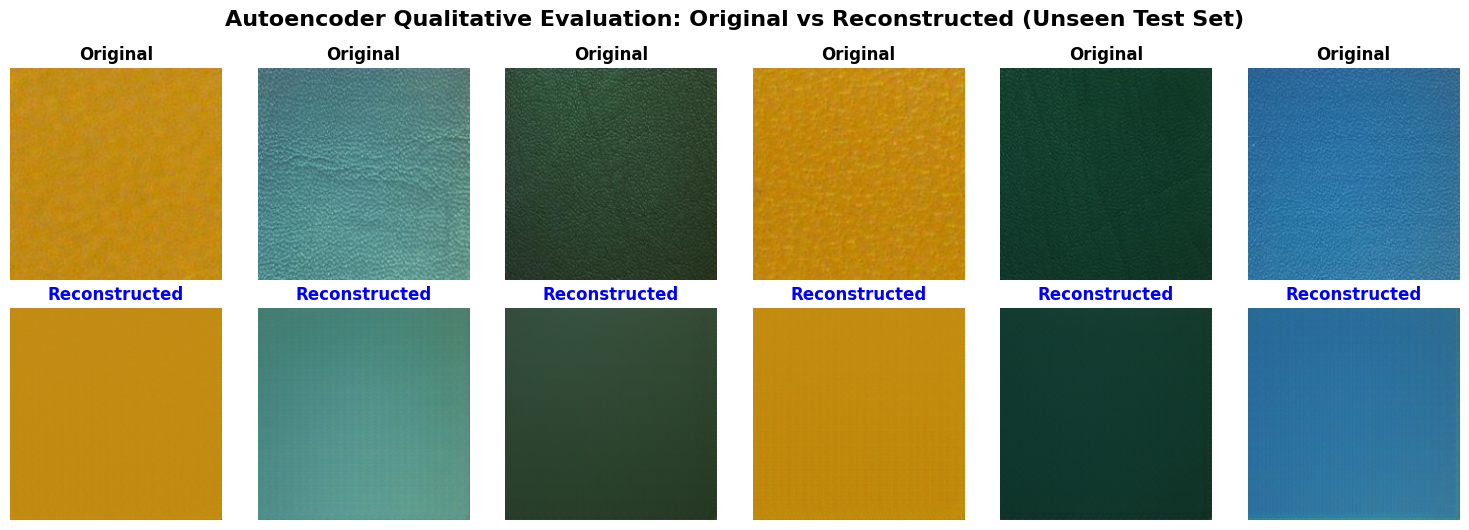

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_reconstructions(model, dataloader, device, num_images=6):
    """
    Plots a grid comparing original images from the dataloader
    with their reconstructed counterparts from the autoencoder.
    """
    # 1. Set model to evaluation mode
    model.eval()

    # 2. Extract a single batch of data
    # We use next(iter()) to just grab the first available batch
    images, _ = next(iter(dataloader))
    images = images.to(device)

    # 3. Generate reconstructions without computing gradients
    with torch.no_grad():
        reconstructed = model(images)

    # Move tensors back to CPU for plotting
    images = images.cpu()
    reconstructed = reconstructed.cpu()

    # 4. Create the Matplotlib figure
    # 2 rows (Original, Reconstructed) x 'num_images' columns
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        # --- PLOT ORIGINAL ---
        plt.subplot(2, num_images, i + 1)
        # Convert tensor (C, H, W) to numpy array (H, W, C)
        # Since we only used ToTensor(), the pixels are already in [0, 1]
        img_orig = images[i].numpy().transpose((1, 2, 0))
        plt.imshow(img_orig)
        plt.title("Original", fontsize=12, fontweight='bold')
        plt.axis('off')

        # --- PLOT RECONSTRUCTED ---
        plt.subplot(2, num_images, i + 1 + num_images)
        img_recon = reconstructed[i].numpy().transpose((1, 2, 0))
        plt.imshow(img_recon)
        plt.title("Reconstructed", fontsize=12, fontweight='bold', color='blue')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Autoencoder Qualitative Evaluation: Original vs Reconstructed (Unseen Test Set)",
                 fontsize=16, fontweight='bold', y=1.05)
    plt.show()

# Load the absolute best weights we found during the Grid Search
best_model_path = os.path.join(SAVE_DIR, "AUTOENCODER_GLOBAL_BEST.pth")

# Initialize a fresh model and inject the winning weights
best_autoencoder = ConvolutionalAutoencoder(latent_dim=256).to(device)
best_autoencoder.load_state_dict(torch.load(best_model_path))

# Call the visualization function using the unseen test_loader
print("Visualizing reconstructions from the Test Set...")
visualize_reconstructions(best_autoencoder, test_loader, device, num_images=6)

# **Second Trial**

In [ ]:
class HighResEncoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(HighResEncoder, self).__init__()

        # 4 Blocks instead of 5. Stops at 14x14 spatial resolution.
        self.encoder_cnn = nn.Sequential(
            # 224 -> 112
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 112 -> 56
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 56 -> 28
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 28 -> 14
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.flatten = nn.Flatten()
        # 256 channels * 14 height * 14 width = 50176
        self.fc_latent = nn.Linear(256 * 14 * 14, latent_dim)

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        return self.fc_latent(x)

class HighResDecoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(HighResDecoder, self).__init__()

        self.fc_expand = nn.Linear(latent_dim, 256 * 14 * 14)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 14, 14))

        # 4 Blocks to upsample back from 14x14 to 224x224
        self.decoder_cnn = nn.Sequential(
            # 14 -> 28
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 28 -> 56
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 56 -> 112
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 112 -> 224
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.fc_expand(x)
        x = self.unflatten(x)
        return self.decoder_cnn(x)

class HighResAutoencoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(HighResAutoencoder, self).__init__()
        self.encoder = HighResEncoder(latent_dim)
        self.decoder = HighResDecoder(latent_dim)

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [ ]:
REPO_PATH = '/content/drive/MyDrive/00gerem00/DL-AI-Project/'
HIGH_RES_DIR = os.path.join(REPO_PATH, 'models_high_res')
os.makedirs(HIGH_RES_DIR, exist_ok=True)

# --- 2. MODEL INITIALIZATION ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
high_res_model = HighResAutoencoder(latent_dim=1024).to(device)

# Using L1 Loss for sharper edge reconstruction
criterion = nn.L1Loss()
optimizer = optim.Adam(high_res_model.parameters(), lr=0.0005)

num_epochs = 60
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)

# Tracking history for later visualization
hr_history = {'train_l1': [], 'val_l1': [], 'lr': []}

# --- 3. TRAINING LOOP ---
print("Starting High-Res Autoencoder Training...")
best_val_l1 = float('inf')

for epoch in range(num_epochs):
    high_res_model.train()
    running_loss = 0.0

    for inputs, _ in train_loader:
        inputs = inputs.to(device)
        optimizer.zero_grad()
        outputs = high_res_model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    high_res_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            outputs = high_res_model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    hr_history['train_l1'].append(train_loss)
    hr_history['val_l1'].append(val_loss)
    hr_history['lr'].append(current_lr)

    print(f"Epoch [{epoch+1:02d}/{num_epochs}] | Train L1: {train_loss:.5f} | Val L1: {val_loss:.5f} | LR: {current_lr:.6f}")

    # --- 4. SAVE BEST WEIGHTS ---
    if val_loss < best_val_l1:
        best_val_l1 = val_loss
        best_path = os.path.join(HIGH_RES_DIR, 'HIGH_RES_BEST_MODEL.pth')
        torch.save(high_res_model.state_dict(), best_path)

# --- 5. SAVE FINAL LOGS ---
with open(os.path.join(HIGH_RES_DIR, 'high_res_training_logs.json'), 'w') as f:
    json.dump(hr_history, f)

Starting High-Res Autoencoder Training...
Epoch [01/60] | Train L1: 0.10228 | Val L1: 0.06177 | LR: 0.000500
Epoch [02/60] | Train L1: 0.05676 | Val L1: 0.05615 | LR: 0.000500
Epoch [03/60] | Train L1: 0.04976 | Val L1: 0.04280 | LR: 0.000500
Epoch [04/60] | Train L1: 0.04460 | Val L1: 0.04236 | LR: 0.000500
Epoch [05/60] | Train L1: 0.04346 | Val L1: 0.03880 | LR: 0.000500
Epoch [06/60] | Train L1: 0.04034 | Val L1: 0.03383 | LR: 0.000500
Epoch [07/60] | Train L1: 0.03931 | Val L1: 0.03789 | LR: 0.000500
Epoch [08/60] | Train L1: 0.04073 | Val L1: 0.03367 | LR: 0.000500
Epoch [09/60] | Train L1: 0.03828 | Val L1: 0.03480 | LR: 0.000500
Epoch [10/60] | Train L1: 0.03794 | Val L1: 0.03217 | LR: 0.000500
Epoch [11/60] | Train L1: 0.03549 | Val L1: 0.03256 | LR: 0.000500
Epoch [12/60] | Train L1: 0.03729 | Val L1: 0.03256 | LR: 0.000500
Epoch [13/60] | Train L1: 0.03733 | Val L1: 0.03199 | LR: 0.000500
Epoch [14/60] | Train L1: 0.03599 | Val L1: 0.03162 | LR: 0.000500
Epoch [15/60] | Trai

Weights successfully loaded from: /content/drive/MyDrive/00gerem00/DL-AI-Project/models_high_res/HIGH_RES_BEST_MODEL.pth
Generating grid...


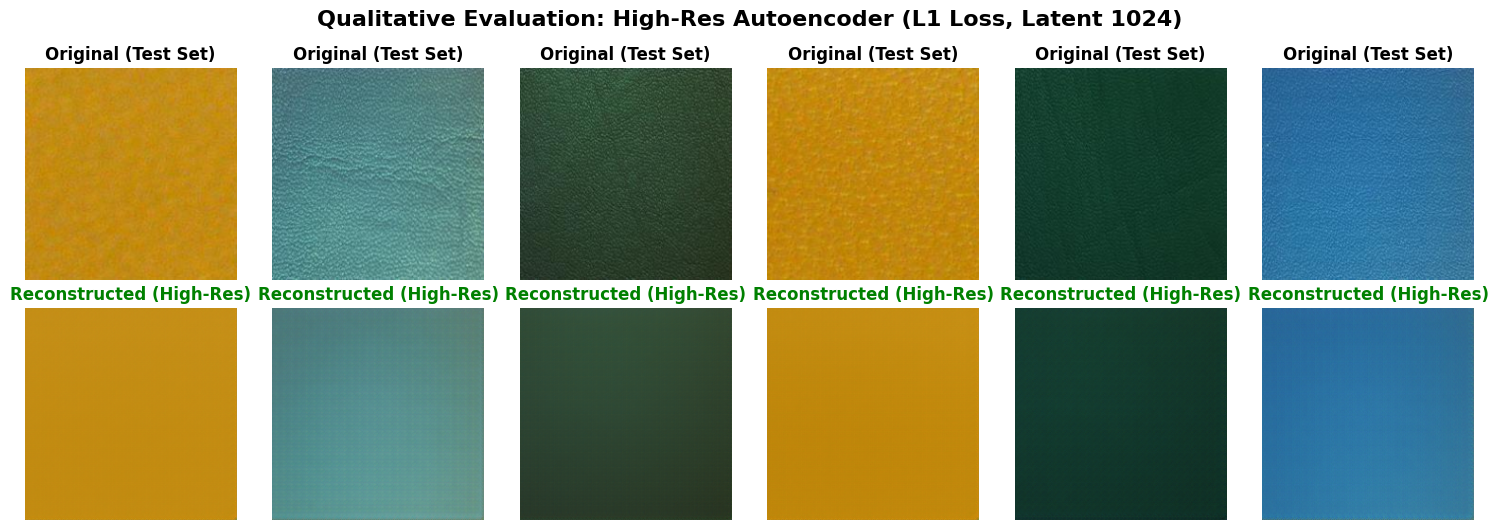

In [ ]:
import matplotlib.pyplot as plt
import torch
import os

def visualize_high_res_reconstructions(model, dataloader, device, num_images=6):
    """
    Plots a grid comparing original images from the Test Set
    with the reconstructions generated by the High-Res Autoencoder.
    """
    model.eval()

    # Fetch a single batch from the Test Set
    images, _ = next(iter(dataloader))
    images = images.to(device)

    # Generate reconstructions without computing gradients
    with torch.no_grad():
        reconstructed = model(images)

    # Move tensors to CPU for plotting with Matplotlib
    images = images.cpu()
    reconstructed = reconstructed.cpu()

    # Create the visual grid
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        # --- ORIGINAL PLOT ---
        plt.subplot(2, num_images, i + 1)
        # Convert from (Channels, Height, Width) to (Height, Width, Channels)
        img_orig = images[i].numpy().transpose((1, 2, 0))
        plt.imshow(img_orig)
        plt.title("Original (Test Set)", fontsize=12, fontweight='bold')
        plt.axis('off')

        # --- RECONSTRUCTED PLOT (HIGH-RES) ---
        plt.subplot(2, num_images, i + 1 + num_images)
        img_recon = reconstructed[i].numpy().transpose((1, 2, 0))
        plt.imshow(img_recon)
        plt.title("Reconstructed (High-Res)", fontsize=12, fontweight='bold', color='green')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Qualitative Evaluation: High-Res Autoencoder (L1 Loss, Latent 1024)",
                 fontsize=16, fontweight='bold', y=1.05)
    plt.show()

# ==============================================================================
# LOADING AND EXECUTION
# ==============================================================================
# Define paths (same as training)
REPO_PATH = '/content/drive/MyDrive/00gerem00/DL-AI-Project/'
HIGH_RES_DIR = os.path.join(REPO_PATH, 'models_high_res')
best_path = os.path.join(HIGH_RES_DIR, 'HIGH_RES_BEST_MODEL.pth')

# Initialize the empty model
best_hr_model = HighResAutoencoder(latent_dim=1024).to(device)

# Load the trained weights
best_hr_model.load_state_dict(torch.load(best_path, map_location=device))
print(f"Weights successfully loaded from: {best_path}")

# Launch the visual function!
print("Generating grid...")
visualize_high_res_reconstructions(best_hr_model, test_loader, device, num_images=6)

# **Autoencoder Fully Convolutional**

In [ ]:
import torch
import torch.nn as nn

class FullyConvEncoder(nn.Module):
    def __init__(self):
        super(FullyConvEncoder, self).__init__()
        self.encoder_cnn = nn.Sequential(
            # 224x224x3 -> 112x112x32
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 112x112x32 -> 56x56x64
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 56x56x64 -> 28x28x128
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 28x28x128 -> 14x14x256
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # IL NUOVO BOTTLENECK SPAZIALE: 14x14x64
            # Niente Flatten! Manteniamo la griglia 14x14 ma riduciamo i canali a 64
            nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.encoder_cnn(x)

class FullyConvDecoder(nn.Module):
    def __init__(self):
        super(FullyConvDecoder, self).__init__()
        self.decoder_cnn = nn.Sequential(
            # Dal bottleneck 14x14x64 torniamo su
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 14x14x256 -> 28x28x128
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 28x28x128 -> 56x56x64
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 56x56x64 -> 112x112x32
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 112x112x32 -> 224x224x3
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder_cnn(x)

class FullyConvAutoencoder(nn.Module):
    def __init__(self):
        super(FullyConvAutoencoder, self).__init__()
        self.encoder = FullyConvEncoder()
        self.decoder = FullyConvDecoder()

    def forward(self, x):
        return self.decoder(self.encoder(x))

# **Model Training**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fcae_model = FullyConvAutoencoder().to(device)

In [ ]:
import time
import os
import torch
import torch.optim as optim
import json

# --- 1. DIRECTORY CONFIGURATION ---
REPO_PATH = '/content/drive/MyDrive/00gerem00/DL-AI-Project/'
FULLY_CONV_DIR = os.path.join(REPO_PATH, 'models_fully_conv')
os.makedirs(FULLY_CONV_DIR, exist_ok=True)

print(f"Save directory ready: {FULLY_CONV_DIR}")
print("Initializing Fully Convolutional Autoencoder...")

# Reverting to MSE Loss, which is optimal for Fully Convolutional models
criterion = nn.MSELoss()

# Retaining the optimal learning rate
optimizer = optim.Adam(fcae_model.parameters(), lr=0.0005)

# Setup learning rate scheduler and history tracking
num_epochs = 60
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=4)
fcae_history = {'train_mse': [], 'val_mse': [], 'lr': []}

# --- 3. TRAINING LOOP ---
print("Starting FCAE Training...")
best_val_mse = float('inf')

for epoch in range(num_epochs):
    fcae_model.train()
    running_loss = 0.0

    for inputs, _ in train_loader:
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = fcae_model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    train_loss = running_loss / len(train_loader.dataset)

    # Validation
    fcae_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            outputs = fcae_model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']

    # Save epoch history
    fcae_history['train_mse'].append(train_loss)
    fcae_history['val_mse'].append(val_loss)
    fcae_history['lr'].append(current_lr)

    print(f"Epoch [{epoch+1:02d}/{num_epochs}] | Train MSE: {train_loss:.6f} | Val MSE: {val_loss:.6f} | LR: {current_lr:.6f}")

    # --- 4. SAVE BEST MODEL WEIGHTS ---
    if val_loss < best_val_mse:
        best_val_mse = val_loss
        best_path = os.path.join(FULLY_CONV_DIR, 'FCAE_BEST_MODEL.pth')
        torch.save(fcae_model.state_dict(), best_path)

# --- 5. SAVE FINAL TRAINING LOGS ---
with open(os.path.join(FULLY_CONV_DIR, 'fcae_training_logs.json'), 'w') as f:
    json.dump(fcae_history, f)

print(f"\nFCAE Training completed! Best Val MSE: {best_val_mse:.6f}")

Save directory ready: /content/drive/MyDrive/00gerem00/DL-AI-Project/models_fully_conv
Initializing Fully Convolutional Autoencoder...
Starting FCAE Training...
Epoch [01/60] | Train MSE: 0.030649 | Val MSE: 0.008415 | LR: 0.000500
Epoch [02/60] | Train MSE: 0.006982 | Val MSE: 0.004634 | LR: 0.000500
Epoch [03/60] | Train MSE: 0.004183 | Val MSE: 0.002596 | LR: 0.000500
Epoch [04/60] | Train MSE: 0.003634 | Val MSE: 0.002405 | LR: 0.000500
Epoch [05/60] | Train MSE: 0.003161 | Val MSE: 0.002934 | LR: 0.000500
Epoch [06/60] | Train MSE: 0.003010 | Val MSE: 0.003684 | LR: 0.000500
Epoch [07/60] | Train MSE: 0.002451 | Val MSE: 0.001453 | LR: 0.000500
Epoch [08/60] | Train MSE: 0.002096 | Val MSE: 0.002130 | LR: 0.000500
Epoch [09/60] | Train MSE: 0.002165 | Val MSE: 0.001802 | LR: 0.000500
Epoch [10/60] | Train MSE: 0.002075 | Val MSE: 0.001494 | LR: 0.000500
Epoch [11/60] | Train MSE: 0.001929 | Val MSE: 0.001367 | LR: 0.000500
Epoch [12/60] | Train MSE: 0.002105 | Val MSE: 0.001344 | 

Weights successfully loaded from: /content/drive/MyDrive/00gerem00/DL-AI-Project/models_fully_conv/FCAE_BEST_MODEL.pth
Generating evaluation grid...


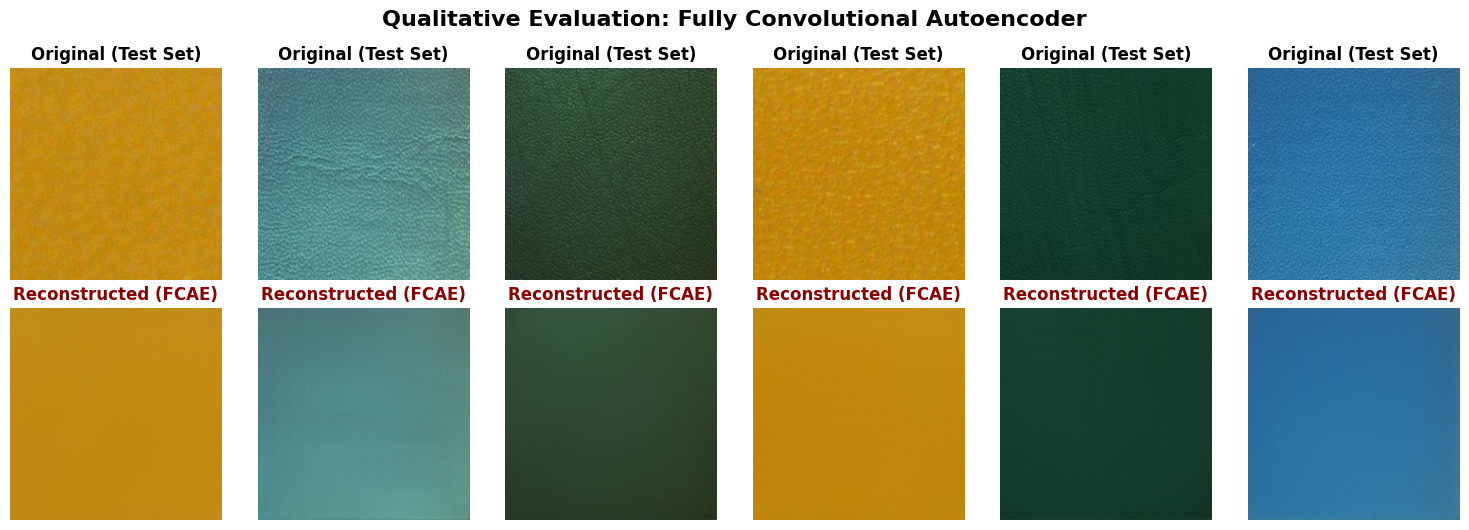

In [ ]:
import matplotlib.pyplot as plt
import torch
import os

def visualize_fcae_reconstructions(model, dataloader, device, num_images=6):
    """
    Plots a grid comparing original images from the Test Set
    with the reconstructions generated by the Fully Convolutional Autoencoder.
    """
    model.eval()

    # Fetch a single batch from the Test Set
    images, _ = next(iter(dataloader))
    images = images.to(device)

    # Generate reconstructions without computing gradients
    with torch.no_grad():
        reconstructed = model(images)

    # Move tensors to CPU for plotting with Matplotlib
    images = images.cpu()
    reconstructed = reconstructed.cpu()

    # Create the visual grid
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        # --- ORIGINAL PLOT ---
        plt.subplot(2, num_images, i + 1)
        # Convert from (Channels, Height, Width) to (Height, Width, Channels) for Matplotlib
        img_orig = images[i].numpy().transpose((1, 2, 0))
        plt.imshow(img_orig)
        plt.title("Original (Test Set)", fontsize=12, fontweight='bold')
        plt.axis('off')

        # --- RECONSTRUCTED PLOT (FCAE) ---
        plt.subplot(2, num_images, i + 1 + num_images)
        img_recon = reconstructed[i].numpy().transpose((1, 2, 0))
        plt.imshow(img_recon)
        plt.title("Reconstructed (FCAE)", fontsize=12, fontweight='bold', color='darkred')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Qualitative Evaluation: Fully Convolutional Autoencoder",
                 fontsize=16, fontweight='bold', y=1.05)
    plt.show()

# ==============================================================================
# LOADING AND EXECUTION
# ==============================================================================
# Define paths based on the training configuration
REPO_PATH = '/content/drive/MyDrive/00gerem00/DL-AI-Project/'
FULLY_CONV_DIR = os.path.join(REPO_PATH, 'models_fully_conv')
best_path = os.path.join(FULLY_CONV_DIR, 'FCAE_BEST_MODEL.pth')

# Initialize the empty Fully Convolutional model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_fcae_model = FullyConvAutoencoder().to(device)

# Load the trained weights
best_fcae_model.load_state_dict(torch.load(best_path, map_location=device))
print(f"Weights successfully loaded from: {best_path}")

# Launch the visual function
print("Generating evaluation grid...")
visualize_fcae_reconstructions(best_fcae_model, test_loader, device, num_images=6)

# **SSIM Loss Function**

In [7]:
import torch
import torch.nn as nn

class FullyConvEncoder(nn.Module):
    def __init__(self):
        super(FullyConvEncoder, self).__init__()
        self.encoder_cnn = nn.Sequential(
            # 224x224x3 -> 112x112x32
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 112x112x32 -> 56x56x64
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 56x56x64 -> 28x28x128
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 28x28x128 -> 14x14x256
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # IL NUOVO BOTTLENECK SPAZIALE: 14x14x64
            # Niente Flatten! Manteniamo la griglia 14x14 ma riduciamo i canali a 64
            nn.Conv2d(256, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.encoder_cnn(x)

class FullyConvDecoder(nn.Module):
    def __init__(self):
        super(FullyConvDecoder, self).__init__()
        self.decoder_cnn = nn.Sequential(
            # Dal bottleneck 14x14x64 torniamo su
            nn.Conv2d(64, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 14x14x256 -> 28x28x128
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 28x28x128 -> 56x56x64
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 56x56x64 -> 112x112x32
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 112x112x32 -> 224x224x3
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder_cnn(x)

class FullyConvAutoencoder(nn.Module):
    def __init__(self):
        super(FullyConvAutoencoder, self).__init__()
        self.encoder = FullyConvEncoder()
        self.decoder = FullyConvDecoder()

    def forward(self, x):
        return self.decoder(self.encoder(x))

# **Defining the new Loss Function**

In [8]:
import torch.nn.functional as F

class LeatherStructuralLoss(nn.Module):
    def __init__(self, alpha=0.84, window_size=5):
        super(LeatherStructuralLoss, self).__init__()
        self.alpha = alpha
        self.window_size = window_size
        self.C1 = 0.01**2
        self.C2 = 0.03**2

    def compute_ssim(self, img1, img2):
        mu1 = F.avg_pool2d(img1, self.window_size, stride=1, padding=self.window_size//2)
        mu2 = F.avg_pool2d(img2, self.window_size, stride=1, padding=self.window_size//2)

        mu1_sq, mu2_sq, mu1_mu2 = mu1.pow(2), mu2.pow(2), mu1 * mu2

        sigma1_sq = F.avg_pool2d(img1 * img1, self.window_size, stride=1, padding=self.window_size//2) - mu1_sq
        sigma2_sq = F.avg_pool2d(img2 * img2, self.window_size, stride=1, padding=self.window_size//2) - mu2_sq
        sigma12 = F.avg_pool2d(img1 * img2, self.window_size, stride=1, padding=self.window_size//2) - mu1_mu2

        num = (2 * mu1_mu2 + self.C1) * (2 * sigma12 + self.C2)
        den = (mu1_sq + mu2_sq + self.C1) * (sigma1_sq + sigma2_sq + self.C2)

        return (num / (den + 1e-7)).mean()

    def forward(self, prediction, target):
        ssim_val = self.compute_ssim(prediction, target)
        l1_loss = F.l1_loss(prediction, target)
        return (self.alpha * (1 - ssim_val)) + ((1 - self.alpha) * l1_loss)

# **Model Training**

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FullyConvAutoencoder().to(device)

In [ ]:
import os
import torch
import torch.optim as optim
import json

REPO_PATH = '/content/drive/MyDrive/00gerem00/DL-AI-Project/'
SSIM_Trial1_DIR = os.path.join(REPO_PATH, 'SSIM_Trial1_results')
os.makedirs(SSIM_Trial1_DIR, exist_ok=True)

# Hyperparameters
alpha_test = 0.84
lr_test = 0.0005
num_epochs = 60

# Model, Loss, and Optimizer initialization
model = FullyConvAutoencoder().to(device)
criterion = LeatherStructuralLoss(alpha=alpha_test, window_size=5)
optimizer = optim.Adam(model.parameters(), lr=lr_test)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

history = {'train_loss': [], 'val_loss': [], 'lr': []}
best_val_loss = float('inf')

print(f"Starting SSIM Trial 1: Alpha={alpha_test}, LR={lr_test}")

# --- TRAINING LOOP ---
for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    for inputs, _ in train_loader:
        inputs = inputs.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * inputs.size(0)

    train_loss = train_running_loss / len(train_loader.dataset)

    # Validation
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            v_loss = criterion(outputs, inputs)
            val_running_loss += v_loss.item() * inputs.size(0)

    val_loss = val_running_loss / len(val_loader.dataset)
    scheduler.step(val_loss)

    curr_lr = optimizer.param_groups[0]['lr']
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['lr'].append(curr_lr)

    print(f"Epoch [{epoch+1:02d}/{num_epochs}] | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | LR: {curr_lr:.6f}")

    # Save the best model weights
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_path = os.path.join(SSIM_Trial1_DIR, 'SSIM_Trial1_best.pth')
        torch.save(model.state_dict(), best_model_path)

# --- SAVE TRAINING LOGS ---
logs_path = os.path.join(SSIM_Trial1_DIR, 'SSIM_Trial1_history.json')
with open(logs_path, 'w') as f:
    json.dump(history, f)

print(f"\nSSIM Trial 1 Finished! Best Val Loss: {best_val_loss:.6f}")

Starting SSIM Trial 1: Alpha=0.84, LR=0.0005
Epoch [01/60] | Train Loss: 0.433617 | Val Loss: 0.396747 | LR: 0.000500
Epoch [02/60] | Train Loss: 0.399775 | Val Loss: 0.382579 | LR: 0.000500
Epoch [03/60] | Train Loss: 0.382421 | Val Loss: 0.360145 | LR: 0.000500
Epoch [04/60] | Train Loss: 0.350316 | Val Loss: 0.331916 | LR: 0.000500
Epoch [05/60] | Train Loss: 0.330029 | Val Loss: 0.321293 | LR: 0.000500
Epoch [06/60] | Train Loss: 0.316181 | Val Loss: 0.302000 | LR: 0.000500
Epoch [07/60] | Train Loss: 0.293596 | Val Loss: 0.280278 | LR: 0.000500
Epoch [08/60] | Train Loss: 0.266112 | Val Loss: 0.259324 | LR: 0.000500
Epoch [09/60] | Train Loss: 0.253784 | Val Loss: 0.249559 | LR: 0.000500
Epoch [10/60] | Train Loss: 0.253484 | Val Loss: 0.247019 | LR: 0.000500
Epoch [11/60] | Train Loss: 0.250878 | Val Loss: 0.246705 | LR: 0.000500
Epoch [12/60] | Train Loss: 0.250829 | Val Loss: 0.247844 | LR: 0.000500
Epoch [13/60] | Train Loss: 0.247763 | Val Loss: 0.243875 | LR: 0.000500
Epoch 

Weights successfully loaded from: /content/drive/MyDrive/00gerem00/DL-AI-Project/SSIM_Trial1_results/SSIM_Trial1_best.pth
Generating SSIM Trial 1 evaluation grid...


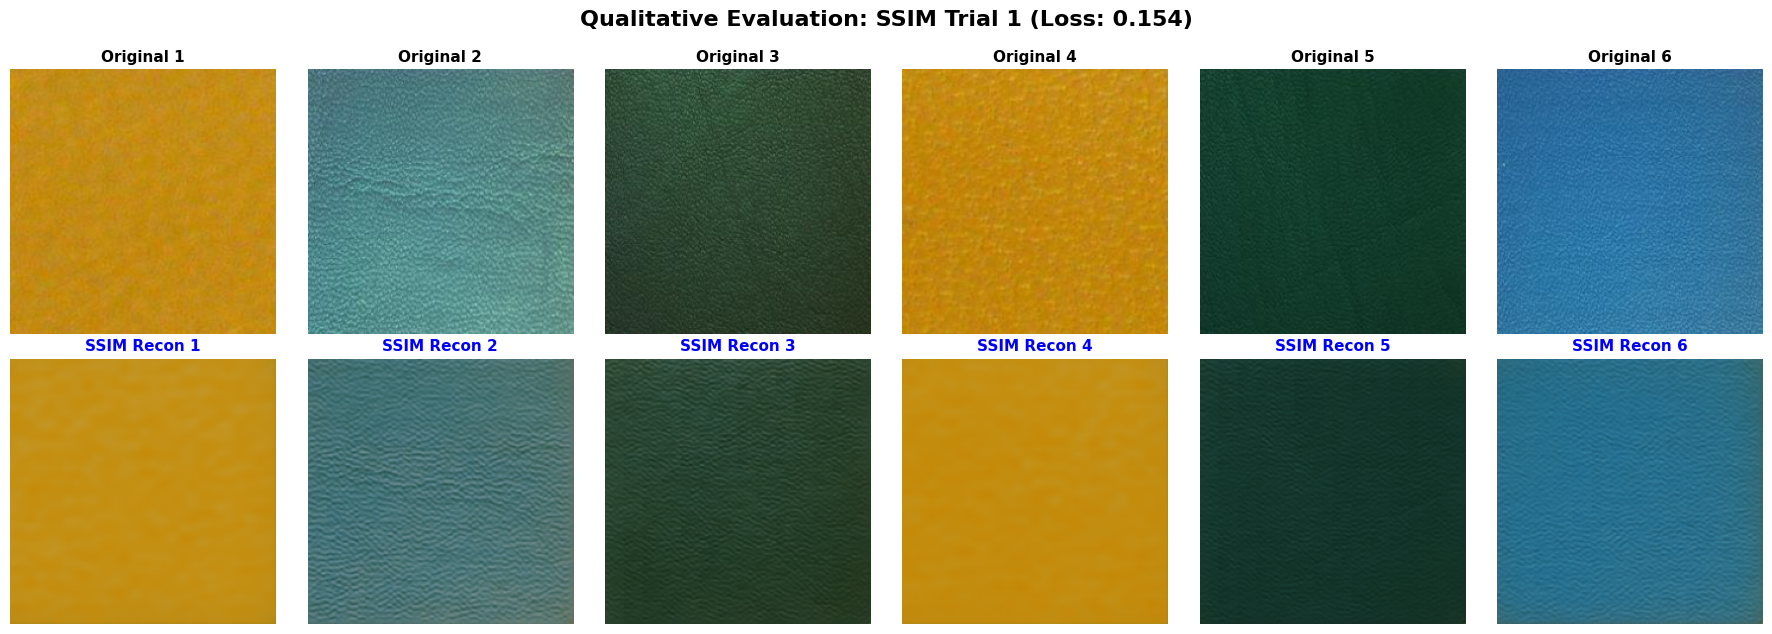

In [ ]:
import matplotlib.pyplot as plt
import torch
import os

def visualize_ssim_reconstructions(model, dataloader, device, num_images=6):
    """
    Plots a grid comparing original images from the Test Set
    with the reconstructions generated by the SSIM-optimized Autoencoder.
    """
    model.eval()

    # Estrazione di un batch dal Test Set
    # Nota: Assicurati che test_loader sia definito nel tuo notebook
    images, _ = next(iter(dataloader))
    images = images.to(device)

    # Generazione ricostruzioni
    with torch.no_grad():
        reconstructed = model(images)

    # Trasferimento su CPU per il plotting
    images = images.cpu()
    reconstructed = reconstructed.cpu()

    plt.figure(figsize=(18, 6))

    for i in range(num_images):
        # --- ORIGINAL PLOT ---
        plt.subplot(2, num_images, i + 1)
        img_orig = images[i].numpy().transpose((1, 2, 0))
        plt.imshow(img_orig)
        plt.title(f"Original {i+1}", fontsize=11, fontweight='bold')
        plt.axis('off')

        # --- RECONSTRUCTED PLOT (SSIM Trial 1) ---
        plt.subplot(2, num_images, i + 1 + num_images)
        img_recon = reconstructed[i].numpy().transpose((1, 2, 0))
        plt.imshow(img_recon)
        # Titolo in blu per distinguere il miglioramento qualitativo
        plt.title(f"SSIM Recon {i+1}", fontsize=11, fontweight='bold', color='blue')
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Qualitative Evaluation: SSIM Trial 1 (Loss: 0.154)",
                 fontsize=16, fontweight='bold', y=1.05)
    plt.show()

# ==============================================================================
# LOADING AND EXECUTION - SSIM TRIAL 1
# ==============================================================================
REPO_PATH = '/content/drive/MyDrive/00gerem00/DL-AI-Project/'
# Percorso aggiornato alla cartella del nuovo addestramento
SSIM_TRIAL_DIR = os.path.join(REPO_PATH, 'SSIM_Trial1_results')
# Nome del file aggiornato
best_path = os.path.join(SSIM_TRIAL_DIR, 'SSIM_Trial1_best.pth')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Inizializzazione modello
best_ssim_model = FullyConvAutoencoder().to(device)

# Caricamento pesi
if os.path.exists(best_path):
    best_ssim_model.load_state_dict(torch.load(best_path, map_location=device))
    print(f"Weights successfully loaded from: {best_path}")

    # Esecuzione della visualizzazione
    print("Generating SSIM Trial 1 evaluation grid...")
    visualize_ssim_reconstructions(best_ssim_model, test_loader, device, num_images=6)
else:
    print(f"ERRORE: File non trovato in {best_path}. Verifica il percorso sul Drive.")

# **Model Training with Grid Search**

In [10]:
import os
import torch
import torch.optim as optim
import json
import time
import copy

REPO_PATH = '/content/drive/MyDrive/lorenzomeroni02/DL-AI-Project/'
SAVE_DIR = os.path.join(REPO_PATH, 'GridSearch_SSIM')
os.makedirs(SAVE_DIR, exist_ok=True)

lr_values = [0.0005, 0.0001]
window_sizes = [3, 5]
alphas = [0.84, 0.90, 0.95]

num_epochs = 80
patience_es = 10     # Stops training if validation loss plateaus for 10 epochs
patience_sched = 3   # Reduces learning rate if validation loss plateaus for 3 epochs

# Initialize global tracking variables to identify the absolute best model
global_best_loss = float("inf")
global_best_config = None
global_best_model_state = None

results_summary = {}
full_histories = {}


print("STARTING GRID SEARCH WITH FULL MONITORING (LOSS, LR, Alpha, Window_Size, Time)")

for initial_lr in lr_values:
    for win_size in window_sizes:
        for alpha in alphas:
            config_name = f"LR_{initial_lr}_Win_{win_size}_Alpha_{alpha}"

            print("\n" + "="*70)
            print(f"STARTING TRIAL: {config_name}")
            print("="*70)

            # Initialize the Autoencoder
            model = FullyConvAutoencoder().to(device)
            criterion = LeatherStructuralLoss(alpha=alpha, window_size=win_size)
            optimizer = optim.Adam(model.parameters(), lr=initial_lr)

            # Implement adaptive learning rate decay
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=patience_sched
            )

            counter_es = 0
            best_val_loss_current = float("inf")

            history = {
                'train_loss': [],
                'val_loss': [],
                'lr_evolution': [],
                'epoch_duration': []
            }

            for epoch in range(num_epochs):
                start_time = time.time()

                # Record the active learning rate prior to any scheduler updates
                current_lr = optimizer.param_groups[0]['lr']
                history['lr_evolution'].append(current_lr)

                model.train()
                running_loss = 0.0
                total_train = 0

                for inputs, _ in train_loader:
                    inputs = inputs.to(device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    total_train += inputs.size(0)

                train_loss = running_loss / total_train

                # --- Validation Phase ---
                model.eval()
                val_loss = 0.0
                total_val = 0

                with torch.no_grad():
                    for inputs, _ in val_loader:
                        inputs = inputs.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, inputs)

                        val_loss += loss.item() * inputs.size(0)
                        total_val += inputs.size(0)

                val_loss = val_loss / total_val

                # Evaluate validation performance to adjust the learning rate if necessary
                scheduler.step(val_loss)

                duration = time.time() - start_time
                history['epoch_duration'].append(duration)
                history['train_loss'].append(train_loss)
                history['val_loss'].append(val_loss)

                print(f"Epoch [{epoch+1:2d}/{num_epochs}] - Time: {duration:.0f}s - LR: {current_lr:.6f}")
                print(f"  Train -> Loss: {train_loss:.4f}")
                print(f"  Val   -> Loss: {val_loss:.4f}")
                print("-" * 30)

                # --- CHECKPOINTING and EARLY STOPPING LOGIC ---
                if val_loss < best_val_loss_current:
                    # reset the early stopping counter
                    best_val_loss_current = val_loss
                    counter_es = 0

                    # Save the current model weights specific to this configuration
                    trial_path = os.path.join(SAVE_DIR, f"{config_name}_best.pth")
                    torch.save(model.state_dict(), trial_path)

                    # Check if this configuration is better than all previous trials
                    if val_loss < global_best_loss:
                        global_best_loss = val_loss
                        global_best_config = config_name
                        global_best_model_state = copy.deepcopy(model.state_dict())
                        print(f"   *** NEW GLOBAL RECORD! Best Val Loss: {global_best_loss:.4f} ***")
                else:
                    counter_es += 1
                    if counter_es >= patience_es:
                        print(f"Early Stopping triggered at epoch {epoch+1}.")
                        break

            results_summary[config_name] = {
                'best_val_loss': best_val_loss_current
            }
            full_histories[config_name] = history

best_model_path = os.path.join(SAVE_DIR, "AUTOENCODER_GLOBAL_BEST.pth")
torch.save(global_best_model_state, best_model_path)

# Export the summarized results for quick evaluation
summary_json_path = os.path.join(SAVE_DIR, "grid_search_summary.json")
with open(summary_json_path, "w") as f:
    json.dump(results_summary, f, indent=4)

# Export the detailed epoch-by-epoch histories for all configurations
full_logs_json_path = os.path.join(SAVE_DIR, "full_training_logs.json")
with open(full_logs_json_path, "w") as f:
    json.dump(full_histories, f, indent=4)

print("\nGRID SEARCH FINISHED")
print(f"Winning Configuration: {global_best_config}")
print(f"Global Best Loss: {global_best_loss:.4f}")
print(f"All files saved in: {SAVE_DIR}")

STARTING GRID SEARCH WITH FULL MONITORING (LOSS, LR, Alpha, Window_Size, Time)

STARTING TRIAL: LR_0.0005_Win_3_Alpha_0.84
Epoch [ 1/80] - Time: 13s - LR: 0.000500
  Train -> Loss: 0.4067
  Val   -> Loss: 0.3697
------------------------------
   *** NEW GLOBAL RECORD! Best Val Loss: 0.3697 ***
Epoch [ 2/80] - Time: 12s - LR: 0.000500
  Train -> Loss: 0.3748
  Val   -> Loss: 0.3573
------------------------------
   *** NEW GLOBAL RECORD! Best Val Loss: 0.3573 ***
Epoch [ 3/80] - Time: 12s - LR: 0.000500
  Train -> Loss: 0.3400
  Val   -> Loss: 0.3324
------------------------------
   *** NEW GLOBAL RECORD! Best Val Loss: 0.3324 ***
Epoch [ 4/80] - Time: 12s - LR: 0.000500
  Train -> Loss: 0.2806
  Val   -> Loss: 0.2666
------------------------------
   *** NEW GLOBAL RECORD! Best Val Loss: 0.2666 ***
Epoch [ 5/80] - Time: 12s - LR: 0.000500
  Train -> Loss: 0.2601
  Val   -> Loss: 0.2527
------------------------------
   *** NEW GLOBAL RECORD! Best Val Loss: 0.2527 ***
Epoch [ 6/80] - T